In [ ]:
!pip install yfinance
!pip install pandas-ta

In [2]:
import pandas as pd
import numpy as np
import pandas_ta as pd_ta
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date

In [3]:
# global settings 
timeframe: str = '1d'

In [26]:
def fetch_data(ticker: str, timeframe: str): 
  """fetch data from yf"""

  # download stock data from yfinance
  if 'd' in timeframe.lower(): 
    start = '2004-01-01'
  else: 
    start = '2022-09-01'
  df = yf.Ticker(ticker).history(interval=timeframe, start=start, end=str(date.today()))
  
  # preprocess dataframe
  try: 
    df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
  except KeyError: 
    pass

  return df

def create_channel(df, period=30, sma_period=150): 
  """create high low channel"""

  # compute high and low channels
  df['High_CH'] = pd_ta.sma(df['High'], length=period)
  df['Low_CH'] = pd_ta.sma(df['Low'], length=period)
  df['SMA150'] = pd_ta.sma(df['Close'], length=sma_period)

  # remove nans
  df.dropna(inplace=True)
  return df

def identify_setup(df, retrieve_history: int = 100): 
  """find potential setups by looking at breakouts and crossovers in the high-low channel"""
  
  # create a subset of the dataframe
  sub_df = df.iloc[-retrieve_history:][['Close', 'High_CH', 'Low_CH', 'SMA150']]

  # categorize the uptrend, downtrend, and pullback price actions
  sub_df['UPTREND'] = sub_df['Close'] > sub_df['High_CH']
  sub_df['UPTREND'] = sub_df['UPTREND'].apply(lambda x: 1 if True else 0)
  sub_df['DOWNTREND'] = sub_df['Close'] < sub_df['Low_CH']
  sub_df['DOWNTREND'] = sub_df['DOWNTREND'].apply(lambda x: 1 if True else 0)
  sub_df['PULLBACK'] = sub_df['Low_CH'] < sub_df['Close'] < sub_df['High_CH']
  sub_df['PULLBACK'] = sub_df['PULLBACK'].apply(lambda x: 1 if True else 0)

  if sub_df['PULLBACK'].iloc[-2] and not sub_df['PULLBACK'].iloc[-1]: 
    return True
  else: 
    return False


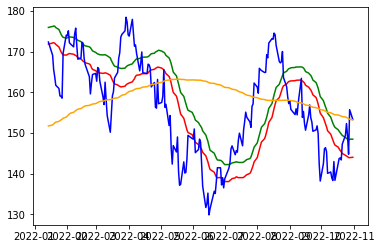

In [25]:
df = fetch_data("AAPl", '1d')
df = create_channel(df, period=30)

history = 200
plt.plot(df['High_CH'][-history:], color='green')
plt.plot(df['Low_CH'][-history:], color='red')
plt.plot(df['Close'][-history:], color='blue')
plt.plot(df['SMA150'][-history:], color='orange')